# Projet d'extraction d'informations à partir de textes
## NLP et Réseau de neurones

### Imports

In [1]:
# Ne pas enlever les % car il permettent le reload de modules ou l'affichage dans le notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import random
import pickle as pkl

import matplotlib.pyplot as plt
import math
import re

import torch
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchtext
from torchtext.legacy.data import Field, TabularDataset, BucketIterator # deprecated since v0.10 so import from legacy code
import spacy

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


device = 'cuda' if T.cuda.is_available() else 'cpu'

c:\users\adepreis\appdata\local\programs\python\python37\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


#### Commandes utiles en cas de librairies manquantes

In [2]:
# pip install torchtext
# !pip3 install -U spacy                       # spaCy lib
# !pip3 install torch torchvision torchaudio   # PyTorch (see <pytorch.org/get-started/locally> for GPU support)
# !python3 -m spacy download en_core_web_trf   # download spaCy trained pipeline

# et pour certains :
# pip install transformers -U

# et pour tester d'autres modèles :
# !python3 -m spacy download xx_ent_wiki_sm    # download spaCy trained pipeline

### File processing

#### File splitting

In [3]:
filename = 'train_label_final.txt'
lines = open(filename,"r", encoding='UTF-8').readlines()
nb_lines = len(lines)
nb_lines_half = math.ceil(nb_lines*0.7)
# Avec le code actuel, comme on fait nb_lines/2 = nb_lines*0.5, la répartition entre les 2 fichiers est de 50%/50%
# Ainsi, si on veut une répartition de 70%/30% pour jeu d'entrainement/validation, il suffit de faire nb_lines*0.7
# --> nb_lines*x , avec x>=0.5 sinon on a 3 fichiers
print(nb_lines_half)

fout = open("output0.txt","wt", encoding='UTF-8')
for i,line in enumerate(lines):
    
    if((i+1)%nb_lines_half) == 0:
        line = str(line).replace('\n', '')
        
    if (i%nb_lines_half) == 0:
        if fout: fout.close()
        fout = open('output%d.txt' % (i/nb_lines_half), 'w', encoding='UTF-8')
        
    fout.write(line)
    
fout.close()

5883


#### File parsing

In [4]:
path = "./output0.txt"
path2 = "./output1.txt"

In [5]:
def convert_txt_to_csv(path, out):
    f = open(path, "r", encoding="UTF-8")
    lines = f.readlines()
    f.close()
    decisions = ["pos", "neg", "neu", "irr"]

    # Future CSV content !
    content = "text,opinion"

    for l in lines:
        # Removing empty lines
        sl = l.split()
        if len(sl) == 0:
            continue

        # Removing no consensus line
        m = re.match(r"[(](.*),(.*),(consensus)[)]", sl[0])
        if m is None:
            continue

        # Parsing opinion
        try:
            opinion = m.string.split(",")[1]
            if opinion in decisions:
                # Opinion string is converted to an integer value
                index = decisions.index(opinion)

                # Removing opinion
                text = re.sub(r"[(](.*),(.*),(consensus)[)]", "", l)

                # Removing comma since comma is CSV separator
                text = text.replace(",", " ")

                # Remvoing extra \n
                text = text.replace("\n", " ")

                # Removing extra space
                text = ' '.join(text.split())

                content = content + "\n" + text + "," + str(index) 
            else:
                # Found opinion is... Wrong !
                continue
        except:
            # Opinion is not found on the line
            continue

    # Writing CSV content to out file
    csv = open(out, "w", encoding="UTF-8")
    csv.write(content)
    csv.close()

In [6]:
convert_txt_to_csv(path, "dataset.csv")
convert_txt_to_csv(path2, "dataset2.csv")

### Lecture et traitement des données & Tokenization

#### Méthode de Tokenization

In [7]:
spacy_en = spacy.load('en_core_web_trf')

# TODO: find a way to merge EN & FR language pipelines :
#spacy_xx = spacy.load('xx_ent_wiki_sm') # multi language
# --> moins bien dans notre cas car moins spécifiquement entrainé sur un langage en particulier. De plus, la taille du fichier telecharge ici est beaucoup plus petit.

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)] # TODO: also use 'attribute_ruler' and 'lemmatizer' ?

#### Prétraitement sur le texte

In [8]:
X_constructor = Field(sequential = True, lower = True, include_lengths = False,
            pad_token = "<pad>", unk_token = "<unk>",
            batch_first = True, tokenize = tokenizer)

Y_constructor = Field(sequential=False, use_vocab=False)

#### Création des datasets

In [9]:
train_dataset, test_dataset = TabularDataset.splits(
    path="./", format="csv", 
    train='dataset.csv', test='dataset2.csv',
    skip_header = True,
    fields=[('x', X_constructor), ('y', Y_constructor)])

#train_dataset[0].x

#### Gestion des batchs

In [10]:
batch_size = 128 # pour la validation on fait varier entre 16 et 256 par pas de 16

train_iter, test_iter = BucketIterator.splits(
    (train_dataset, test_dataset), batch_size=batch_size, #batch_sizes=(16, 256) --> min=16 and max=256
    sort_key = lambda m: len(m.x), device=device,
    sort_within_batch = True, shuffle = True, repeat=False)

#### Gestion du vocabulaire et des word Embeddings

In [11]:
X_constructor.build_vocab(train_dataset, min_freq=2, vectors = 'glove.6B.50d')

batch = next(iter(train_iter))

batch.x

tensor([[ 209,    4,  306,  ...,    0,   14,    0],
        [  15,    0,    7,  ...,   64,    0,   19],
        [  10,   57,  178,  ...,  143,  141,    4],
        ...,
        [ 316,  452,   34,  ...,    1,    1,    1],
        [   2,    5, 1137,  ...,    1,    1,    1],
        [   0,   27,  111,  ...,    1,    1,    1]])

### Création du modèle

In [12]:
class Model(nn.Module):
    def __init__(self, embedding_dim=50):
        super(Model, self).__init__()
        self.embeddings = nn.Embedding.from_pretrained(X_constructor.vocab.vectors, freeze = False)
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = embedding_dim, num_layers = 3, batch_first = True, bidirectional = False)
        self.fc = nn.Linear(embedding_dim, 4) # {pos,neg,neu,irr}
        self.softmax = nn.LogSoftmax(dim=1) # couche d'activation
    
    def forward(self, inputs):
        embeds = self.embeddings(inputs) # pour faire le lien entre indice et vecteur du mot associé
        outputs, (h_n,c_n) = self.lstm(embeds)
        y = h_n[0]
        y = self.fc(y)
        #return y
        preds = self.softmax(y) # couche d'activation
        return preds

In [13]:
model = Model(embedding_dim = 50).to(device)
# embedding_dim = 50 car la taille de chaque vecteur de représentation des mots par l'embedding utilisé à partir de
# la base du fichier "glove.6B.50d", est de taille 50.

In [14]:
model

Model(
  (embeddings): Embedding(1981, 50)
  (lstm): LSTM(50, 50, num_layers=3, batch_first=True)
  (fc): Linear(in_features=50, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
)

### Boucles d'entraînement et de mesure des performances

In [15]:
def collate(batch):
    transposed_data = list(zip(*batch))
    return T.stack(transposed_data[0], 0), T.stack(transposed_data[1], 0)

def train(epochs=100, batch_size=batch_size, lr = 1e-3):
    
    optimizer = T.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss() # Pour calculer la crossentropy, il faut calculer la NLLL après un logsofmax
    #criterion = nn.CrossEntropyLoss()
    
    """
    #trn_X = T.tensor(train_X, dtype=T.float)
    #trn_Y = T.tensor(train_Y, dtype=T.long)
    
    #vld_X = T.tensor(valid_X, dtype=T.float)
    #vld_Y = T.tensor(valid_Y, dtype=T.long)
    
    train_set = data.TensorDataset(trn_X, trn_Y)
    valid_set = data.TensorDataset(vld_X, vld_Y)
    """
    
    """
    ## Creation des loaders
    train_sampler = data.BatchSampler(data.RandomSampler(range(len(train_X))), batch_size, False)
    valid_sampler = data.BatchSampler(data.SequentialSampler(range(len(valid_X))), len(valid_X), False)
    
    train_loader = data.DataLoader(train_set, batch_sampler=train_sampler, collate_fn=collate)
    valid_loader = data.DataLoader(valid_set, batch_sampler=valid_sampler, collate_fn=collate)
    """
    
    losses = []
    f1_valid = []
        
    for e in range(epochs):
        model.train() #passe votre modele en phase d'entrainement
        
        for batch in train_iter:
        #for i in range(0, train_iter.batch_size):
            try:
                #optimizer.zero_grad()
                
                #batch = next(iter(train_iter))
                data = batch.x.to(device)
                labels = batch.y.to(device)

                preds = model(data)
                loss = criterion(preds, labels)
                
                losses.append(loss.item())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            except:
                print("not done")
                
        #optimizer.zero_grad()
        model.eval()

        
        with torch.no_grad():
            for batch in test_iter:
            #for j in range(0, test_iter.batch_size):
                try:
                    #batch = next(iter(test_iter))
                    data = batch.x.to(device)
                    labels = batch.y.to(device)

                    preds_val = model(data)
                    preds = T.argmax(preds_val, dim=1)
                    #_, preds = torch.max(preds_val.data, 1)
                    
                    f1_valid.append(f1_score(labels.to('cpu').numpy(), preds.to('cpu').numpy(), average='micro',
                                labels=[i for i in range(4)]))
                except:
                    print("error")

        print(f"F1 {e}/{epochs}: {f1_valid[-1]}")
        
    
    return model, losses, f1_valid

In [16]:
model, losses, f1_valid = train(epochs=200, lr=1e-4) # batch_size=(batch_size = 128) ici
# De base : epochs=100, batch_size=64, lr = 1e-3

F1 0/200: 0.22033898305084745
F1 1/200: 0.22033898305084745
F1 2/200: 0.22033898305084745
F1 3/200: 0.2966101694915254
F1 4/200: 0.3050847457627119
F1 5/200: 0.3050847457627119
F1 6/200: 0.3050847457627119
F1 7/200: 0.3050847457627119
F1 8/200: 0.3050847457627119
F1 9/200: 0.3050847457627119
F1 10/200: 0.3050847457627119
F1 11/200: 0.3050847457627119
F1 12/200: 0.3050847457627119
F1 13/200: 0.3050847457627119
F1 14/200: 0.3050847457627119
F1 15/200: 0.3050847457627119
F1 16/200: 0.3135593220338983
F1 17/200: 0.3474576271186441
F1 18/200: 0.4152542372881356
F1 19/200: 0.4745762711864407
F1 20/200: 0.4830508474576271
F1 21/200: 0.5
F1 22/200: 0.5169491525423728
F1 23/200: 0.5169491525423728
F1 24/200: 0.5169491525423728
F1 25/200: 0.5169491525423728
F1 26/200: 0.5169491525423728
F1 27/200: 0.5169491525423728
F1 28/200: 0.5
F1 29/200: 0.5169491525423728
F1 30/200: 0.5
F1 31/200: 0.5084745762711864
F1 32/200: 0.5
F1 33/200: 0.5
F1 34/200: 0.5
F1 35/200: 0.5
F1 36/200: 0.5
F1 37/200: 0.5
F1

### Résultats et scores

#### Losses

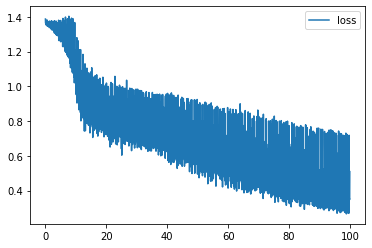

In [17]:
plt.plot([x/(len(losses)/100) for x in range(len(losses))],losses, label="loss")
plt.legend(loc='best')
plt.show()

#### f1_score

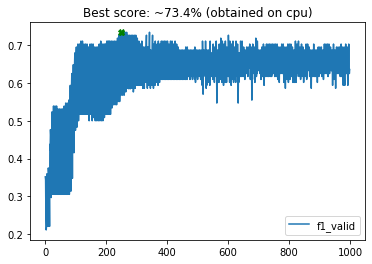

In [18]:
plt.plot(f1_valid, label='f1_valid')
plt.legend(loc='best')

bestIndex = np.argmax(f1_valid)
bestNC, bestScore = np.arange(0, len(f1_valid), 1)[bestIndex], f1_valid[bestIndex]
plt.plot(bestNC, f1_valid[bestIndex], marker='X', color='green')
plt.title("Best score: ~{0:.1%} (obtained on {1})".format(bestScore, device))

plt.show()

#### accuracy_score

In [19]:
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_iter:
    #for j in range(0, test_iter.batch_size):
        try:
            #batch = next(iter(test_iter))
            data = batch.x.to(device)
            labels = batch.y.to(device)

            preds_val = model(data)
            #preds = T.argmax(preds_val, dim=1)
            _, preds = torch.max(preds_val.data, 1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

        except:
            print("error")

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

In [20]:
accuracy_score(all_labels,all_preds)

0.6492063492063492

#### matrice de confusion

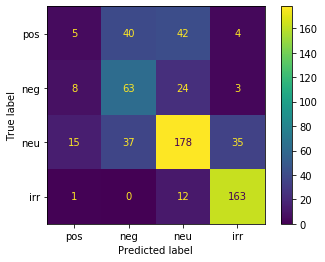

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrice = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=matrice, display_labels=['pos', 'neg', 'neu', 'irr'])
disp.plot()
plt.show()